# BiAAE tutorial

## Load packages

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from models import BiAAE
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from networks import SeqCNNEnc, SeqCNNDec, ImageCNNEnc, ImageCNNDec, Discriminator, ImageCNNEncNp, ImageCNNEncMp

import warnings
warnings.filterwarnings("ignore")

## Load and prepare data

In [2]:
exceldata = pd.read_csv('Training_Data/absorptionData_HybridGAN_Modified.csv', header = 0, index_col = 0)
excelDataSpectra = exceldata.iloc[:,:800].T
file_name = np.asarray(list(excelDataSpectra.keys()), dtype='str')

In [3]:
for i in range(len(file_name)):
    file_name[i] = file_name[i][:-4]
np.random.shuffle(file_name)

In [4]:
spectra = []
image_data = []
for f in file_name:
    spectra.append(excelDataSpectra[f'{f}.mat'].to_numpy())
    img = Image.open(f'Training_Data/Images/{f}.png')
    img.load()
    image_data.append(np.asarray(img, dtype='int32'))

In [5]:
spectra = np.expand_dims(np.asarray(spectra, dtype='float'), axis=-1)
image_data = np.asarray(image_data, dtype='int32')
image_data = image_data/255.0

## Model Setup

### Build networks

In [6]:
img_shape = image_data.shape[1:]
seq_shape = spectra.shape[1:]
z_dim = 20
j_dim = 10

seq_enc = SeqCNNEnc(
    input_shape=seq_shape,
    latent_dim=z_dim,
    n_filters=[16, 32, 64, 128],
    k_size=3,
    dropout=0.0
)

seq_dec = SeqCNNDec(
    input_shape=z_dim,
    ts_shape=seq_shape,
    n_filters=[128, 64, 32, 16],
    k_size=3
)

img_enc = ImageCNNEncMp(
    input_shape=img_shape,
    latent_dim=z_dim,
    n_filters=[32, 64, 128],
    k_size=3,
    dropout=0.0
)

img_dec = ImageCNNDec(
    input_shape=z_dim,
    img_shape=img_shape,
    n_filters=[128, 64, 32],
    k_size=3
)

disc = Discriminator(input_shape=z_dim*2-j_dim, hidden_unit=64)
dis_x = Discriminator(input_shape=z_dim*2-j_dim, hidden_unit=64)
dis_y = Discriminator(input_shape=z_dim*2-j_dim, hidden_unit=64)

### Define losses and optimizers

In [7]:
def ae_loss_ts(ori_ts, rec_ts):
    ori_ts = tf.squeeze(tf.cast(ori_ts, tf.float32))
    rec_ts = tf.squeeze(rec_ts)
    penalty = tf.math.exp(ori_ts)
    sq_error = tf.math.square(ori_ts - rec_ts)
    psq_error = sq_error * penalty
    return tf.reduce_mean(psq_error)

def ae_loss_im(ori_img, rec_img):
    return tf.keras.metrics.mae(ori_img, rec_img)

def dis_loss(y_pred, y_true):
    return tf.keras.metrics.binary_crossentropy(y_true=y_true, y_pred=y_pred, from_logits=True)

def gen_loss(y_pred, y_true):
    return tf.keras.metrics.binary_crossentropy(y_true=y_true, y_pred=y_pred, from_logits=True)

def con_loss(y_true, y_pred):
    return tf.keras.metrics.sparse_categorical_crossentropy(y_true=y_true, y_pred=y_pred, from_logits=True)

In [8]:
dc_schedule = PolynomialDecay(initial_learning_rate=0.00005, decay_steps=300, end_learning_rate=0.00001, power=0.5)
ge_schedule = PolynomialDecay(initial_learning_rate=0.00005, decay_steps=300, end_learning_rate=0.00001, power=0.5)

In [9]:
dc_opt = tf.keras.optimizers.Adam(dc_schedule)
ge_opt = tf.keras.optimizers.Adam(ge_schedule)

### Build model

In [10]:
model = BiAAE(
    seq_enc=seq_enc,
    seq_dec=seq_dec,
    img_enc=img_enc,
    img_dec=img_dec,
    disc=disc,
    disc_indp_x=dis_x,
    disc_indp_y=dis_y,
    z_dim=z_dim,
    joint_dim=j_dim,
    dis_step=1,
    rec_lamb=7,
    joint_lamb=0.1,
    norm_lamb=0.3,
    x_indp_lamb=1.5,
    y_indp_lamb=1.5
)

In [11]:
model.compile(ts_rec_obj=ae_loss_ts, im_rec_obj=ae_loss_im, dis_opt=dc_opt, dis_obj=dis_loss, gen_opt=ge_opt, gen_obj=gen_loss)

### Load saved model

In [12]:
model.load_weights('saved_model/biaae_ckp')

### Train several epoches to ensure model performance

In [13]:
model.fit(spectra, image_data, epochs=10, batch_size=128)

Epoch 1/10
147/147 [==============================] - 9s 30ms/step - gen_loss: 0.4860 - dis_loss: 1.5257
Epoch 2/10
147/147 [==============================] - 4s 29ms/step - gen_loss: 0.4860 - dis_loss: 1.5311
Epoch 3/10
147/147 [==============================] - 4s 28ms/step - gen_loss: 0.4863 - dis_loss: 1.5232
Epoch 4/10
147/147 [==============================] - 4s 28ms/step - gen_loss: 0.4862 - dis_loss: 1.5206
Epoch 5/10
147/147 [==============================] - 4s 28ms/step - gen_loss: 0.4870 - dis_loss: 1.5228
Epoch 6/10
147/147 [==============================] - 4s 28ms/step - gen_loss: 0.4874 - dis_loss: 1.5330
Epoch 7/10
147/147 [==============================] - 4s 28ms/step - gen_loss: 0.4871 - dis_loss: 1.5250
Epoch 8/10
147/147 [==============================] - 4s 28ms/step - gen_loss: 0.4871 - dis_loss: 1.5257
Epoch 9/10
147/147 [==============================] - 4s 28ms/step - gen_loss: 0.4873 - dis_loss: 1.5278
Epoch 10/10
147/147 [==============================] - 

### Check model performance on reconstruction

#### spectrum reconstruction

In [14]:
seq_latent = model.seqenc.predict(spectra)

In [15]:
seq_rec = model.seqdec.predict(seq_latent)

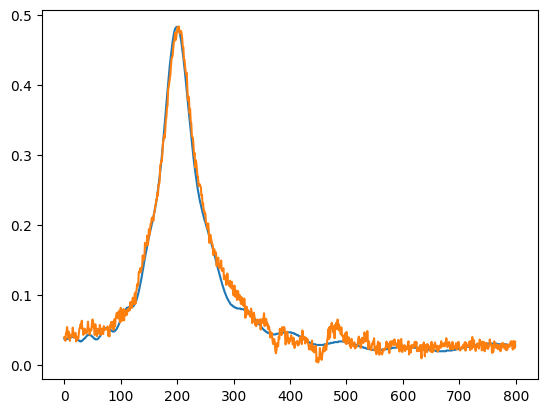

In [16]:
plt.plot(spectra[200])
plt.plot(seq_rec[200])

#### image reconstruction with spectrum latent

In [17]:
seq_z, seq_j = tf.split(seq_latent, [z_dim-j_dim, j_dim], -1)
img_latent = model.imgenc.predict(image_data)
img_z, img_j = tf.split(img_latent, [z_dim-j_dim, j_dim], -1)
swap_latent = tf.concat((img_z, seq_j), axis=-1)       # substitude the shared part of image latent with spectrum latent
img_rec = model.imgdec.predict(swap_latent)

[10822, 3396, 1984, 13078, 16507, 12800, 6745, 7776, 5758, 6073]


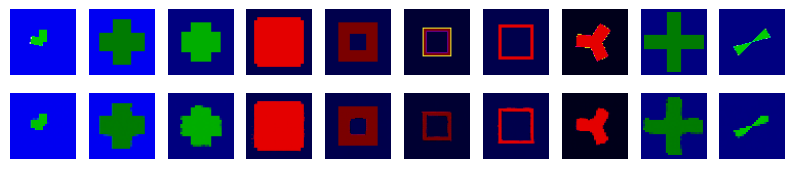

In [18]:
plt.figure(figsize=(10, 2))
ids = []
for i in range(10):
    index = np.random.randint(0, image_data.shape[0])
    ids.append(index)
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow((image_data[index]*255).astype("uint8"))
    plt.axis("off")
    
    ax = plt.subplot(2, 10, i + 11)
    plt.imshow((np.clip(img_rec[index], 0, 1)))
    plt.axis("off")
print(ids)

### Randomly generate new Spectrum

In [19]:
gen_seq_z = tf.random.normal(tf.shape(seq_z), 0, 1)
gen_seq_latent = tf.concat((gen_seq_z, seq_j), axis=-1)
gen_seq = model.seqdec.predict(gen_seq_latent)

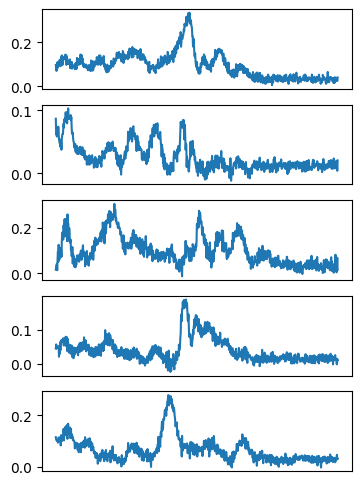

In [20]:
fig, axs = plt.subplots(5, 1, figsize=(4, 6), sharex=True)
for i in range(5):
    rnd_idx = np.random.choice(len(gen_seq))
    s = gen_seq[rnd_idx]
#     axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].plot(s)

### Randomly generate new Images

In [21]:
gen_img_z = tf.random.normal(tf.shape(img_z), 0, 1)
gen_img_latent = tf.concat((gen_img_z, img_j), axis=-1)
gen_img = model.imgdec.predict(gen_img_latent)

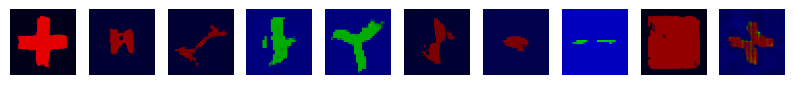

In [22]:
plt.figure(figsize=(10, 2))
for i in range(10):
    index = np.random.randint(0, image_data.shape[0])
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow((np.clip(gen_img[index], 0, 1)))
    plt.axis("off")